# Clasificación de Autos usando SVM e histograma de color

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oscar-ramos/robotica-autonoma-python/blob/main/3-Intro-Vision/3-7-Clasificacion-histogramaColor-SVM.ipynb)

Se desea clasificar si existen o no autos en las imágenes mostradas. Con este fin se utilizará un histograma de color para caracterizar la imagen, y utilizando estos histogramas se entrena un SVM para realizar la clasificación.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import glob

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

## 1.&nbsp;Lectura e Inspección de Imágenes

Si se usa colab se puede descargar y descomprimir las imágenes directamente del repositorio. De lo contrario tendrían que cargarse manualmente o indicar la ruta adecuada a las imágenes

In [ ]:
colab = True
if (colab):
    !wget -q https://github.com/oscar-ramos/robotica-autonoma-python/raw/main/3-Intro-Vision/imagenes/img-autos.zip
    !unzip -qq img-autos.zip
    !rm img-autos.zip

Lectura de los nombres de los archivos. El dataset se divide en dos carpetas: `autos` contiene imágenes de autos, y `otros` contiene imágenes de objetos que no son autos (regions de imágenes de distinto tipo).

In [ ]:
names_cars = glob.glob('img-autos/autos/*.jpeg')
names_notcars = glob.glob('img-autos/otros/*.jpeg')

Se muestra algunas imágenes del conjunto de datos de entrada. Se puede observar imágenes de autos de diferentes tipos y desde distintos ángulos, y también imágenes de regiones que no corresponden a autos.

Imágenes donde hay autos:


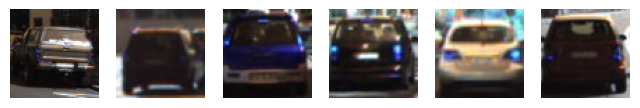

Imágenes donde no hay autos:


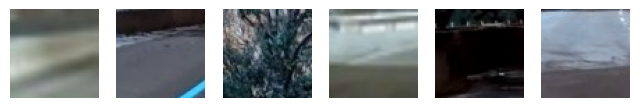

In [ ]:
print("Imágenes donde hay autos:")
plt.subplots(1,6,figsize=(8,8))
for i in range(6):
    Itmp = cv2.imread(names_cars[i])
    plt.subplot(1,6,i+1); plt.axis('off'); plt.imshow(Itmp)
plt.show()

print("Imágenes donde no hay autos:")
plt.subplots(1,6,figsize=(8,8))
for i in range(6):
    Itmp = cv2.imread(names_notcars[i])
    plt.subplot(1,6,i+1); plt.axis('off'); plt.imshow(Itmp)
plt.show()

In [ ]:
print("Número de imágenes de autos:", len(names_cars))
print("Número de imágenes de no autos:", len(names_notcars))
print("Cantidad total de imágenes:", len(names_cars)+len(names_notcars))

Número de imágenes de autos: 1196
Número de imágenes de no autos: 1125
Cantidad total de imágenes: 2321


## 2.&nbsp;Preprocesamiento

Se define 2 funciones para extraer características ("features") de las imágenes:
* `hsv_histogram`: calcula el histograma de HSV. Este histograma contiene el histograma de cada canal H, S y V concatenados. El tamaño del histograma es $3 n_{bins}$, donde $n_{bins}$ es el número de intervalos que tiene el histograma de cada canal.
* `extract_hsv_features`: genera una lista cuyos elementos son los histogramas HSV de cada imagen, calculados con `hsv_histogram`

In [ ]:
def hsv_hist(I, nbins=32, bins_range=(0, 256)):
    """Genera un histograma de HSV normalizado a partir de una imagen RGB. El
    histograma tendrá nbins*3 elementos (debido a los 3 canales de HSV)
    """
    # Convertir la imagen RGB en HSV
    Ihsv = cv2.cvtColor(I, cv2.COLOR_RGB2HSV)
    # Calcular el histograma de los canales HSV por separado
    H_hist = np.histogram(Ihsv[:,:,0], bins=nbins, range=bins_range)
    S_hist = np.histogram(Ihsv[:,:,1], bins=nbins, range=bins_range)
    V_hist = np.histogram(Ihsv[:,:,2], bins=nbins, range=bins_range)
    # Concatenar los 3 histogramas en un solo vector de características ("feature vector")
    HSV_hist = np.concatenate((H_hist[0], S_hist[0], V_hist[0])).astype(np.float64)
    # Normalizar el vector de características resultante
    HSV_hist_norm = HSV_hist / np.sum(HSV_hist)
    # Retornar el vector de características
    return HSV_hist_norm

In [ ]:
# Extrae características de las imágenes
def extract_hsv_features(Inames, hist_bins=32, hist_range=(0, 256)):
    """
    Extrae las características (histograma hsv) de todas las imágenes. Inames
    contiene los nombres de las imágenes. Los otros parámetros se envían
    directamente a hsv_histogram
    """
    # Lista para los vectores de características
    features = []
    # Iterar para todas las imágenes
    for iname in Inames:
        I = cv2.imread(iname)
        # Histograma de color HSV ("features")
        hsv_features = hsv_hist(I, nbins=hist_bins, bins_range=hist_range)
        # Añadir los histogramas a la lista de características
        features.append(hsv_features)

    # Retornar la lista de características (histogramas)
    return features

### 2.1. Extracción de características (histogramas de HSV)

Se extrae las características de cada imagen ("features"), las cuales están constituidas por histogramas HSV normalizados. Cada histograma concatena el histograma del canal H, del canal S y del canal V.

In [ ]:
hist_bins = 32
hist_range = (0, 256)

# Características (histogramas de HSV) de cada imagen
car_features = extract_hsv_features(names_cars, hist_bins, hist_range)
notcar_features = extract_hsv_features(names_notcars, hist_bins, hist_range)

# Arreglo bidimensional con los histogramas (características)
X = np.vstack((car_features, notcar_features))

# Arreglo unidimensional de etiquetas: 1 para autos, 0 para otros
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [ ]:
print("Tamaño de X:", X.shape)
print("Tamaño de y;", y.shape)

Tamaño de X: (2321, 96)
Tamaño de y; (2321,)


Como se observa, el vector de características $X$ tiene un tamaño de 2321 filas y 96 columnas; es decir, cada fila representa un vector característico de una imagen. Por otro lado, el vector de salidas $y$ tiene 2321 elementos, e indica si la fila correspondiente de $X$ es un auto o no lo es.

### 2.2. Normalización

Para una mayor robustez del algoritmo, se realizará la normalización de los histogramas. Para cada atributo (columna del histograma) se le restará la media y se dividirá entre su desviación estándar. Es decir, si el histograma que tiene $m$ atributos es $h=[h_1, h_2, h_3, \cdots, h_m]$, el componente $i$ se normaliza como $h_i = \frac{h_i-\overline{h}_i}{\sigma_i}$, donde $\overline{h}_i$ es la media del atributo $h_i$, y $\sigma_i$ es su desviación estándar.

En Python se puede esta normalización (escalamiento) de manera manual usando la descripción anterior, o utilizando la función [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [ ]:
# Escalador de media y desviación estándar
X_scaler = StandardScaler().fit(X)

# Aplicación del escalador a los datos X
Xscaled = X_scaler.transform(X)

### 2.3. División de los datos

Los datos se dividirán de manera aleatoria en dos conjuntos: uno para el entrenamiento ("train") y otro para la prueba ("test"). Así, los vectores y matrices que se generan son:
* `Xtrain`, `ytrain`: Matriz de atributos y vector de etiquetas del conjunto de entrenamiento.
* `Xtest`, `ytest`: Matriz de atributos y vector de etiquetas del conjunto de prueba o evaluación.

In [ ]:
# Indices
idx = np.arange(len(y))

Xtrain, Xtest, ytrain, ytest, idxtrain, idxtest = train_test_split(Xscaled, y, idx,
                                                                   test_size=0.2,
                                                                   random_state=0)

print('El conjunto original contiene {} autos y {} no autos'.format(len(names_cars), len(names_notcars)))
print('Cada histograma HSV (vector de características) tiene {} elementos'.format(hist_bins*3))

print('\nEl tamaño de los datos X de entrenamiento (Xtrain) es:', Xtrain.shape)
print('El tamaño de las datos X de prueba (Xtest) es:', Xtest.shape)

El conjunto original contiene 1196 autos y 1125 no autos
Cada histograma HSV (vector de características) tiene 96 elementos

El tamaño de los datos X de entrenamiento (Xtrain) es: (1856, 96)
El tamaño de las datos X de prueba (Xtest) es: (465, 96)


## 3.&nbsp;Entrenamiento

En este ejemplo se utilizará SVM (Support Vector Machines) para realizar la clasificación de autos y no autos. Dado que los datos de entrada (histogramas de HSV) ya se encuentran preparados, se podría igualmente utilizar cualquier otro clasificador (con distintos resultados). Por facilidad no se realizará una sintonización de los parámetros sino solo se utilizará un kernel lineal. Para mejorar los resultados se podría también modificar los hiperparámetros del SVM.

In [ ]:
# Instancia de SVM lineal
svm = SVC(kernel='linear')

# Entrenamiento usando el SVM
svm.fit(Xtrain, ytrain);

Para evaluar el entrenamiento realizado con el clasificador utilizado (SVM en este caso), se calculará la "exactitud" en el conjunto de entrenamiento.

In [ ]:
# Predicciones (auto/no auto) en el conjunto de entrenamiento con el SVM entrenado
ytrain_predicted = svm.predict(Xtrain)

# Exactitud en el conjunto de entrenamiento
acc_train = accuracy_score(ytrain_predicted, ytrain)

print('Exactitud en el conjunto de entrenamiento para el SVM lineal:', round(acc_train, 4))

Exactitud en el conjunto de entrenamiento para el SVM lineal: 0.9995


El resultado es alto (cercano a 1), lo cual indica que el desempeño del clasificador es bueno en el conjunto de entrenamiento. A pesar de esto, este valor no indica que se tenga necesariamente un buen clasificador, ya que se podría estar realizando sobreajuste. Para realmente evaluar si se ha logrado obtener un buen clasificador se tiene que evaluar el resultado en el conjunto de prueba o evaluación. En un caso más complejo, se suele utilizar un conjunto de validación o validación cruzada para evaluar el desempeño (y eventualmente mejorar los hiperparámetros) previo al uso del conjunto de prueba o evaluación.

Alternativamente, se obtendrá la matriz de confusión para el conjunto de entrenamiento. Para esto, se puede utilizar la función [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) de scikit-learn.

In [ ]:
confusion_matrix(ytrain, ytrain_predicted)

array([[909,   1],
       [  0, 946]])

## 4.&nbsp;Evaluación

Usando el clasificador SVM entrenado se realizará predicciones sobre el conjunto de prueba o entrenamiento, y se evaluará la exactitud del clasificador entrenado en este conjunto. El resultado obtenido es más relevante que el obtenido en el conjunto de prueba, dado que esta es realmente una evaluación sobre datos que el clasificador no ha visto anteriormente (que es finalmente lo que se desea con un clasificador).

In [ ]:
# Predicción del SVM en el conjunto de prueba
ytest_predicted = svm.predict(Xtest)

# Exactitud
acc_test = accuracy_score(ytest_predicted, ytest)
print('Exactitud en el conjunto de prueba para SVM lineal:', round(acc_test, 4))

Exactitud en el conjunto de prueba para SVM lineal: 0.9935


La exactitud alta muestra que este clasificador es bastante adecuado en este problema en particular. Finalmente, solo a modo de verificación, se moestrará algunas imágenes del conjunto de prueba junto con los valores que el sistema predice para dichas imágenes (si es auto o si no es auto).

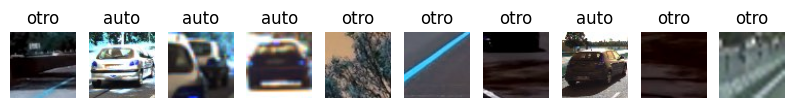

In [ ]:
n = 10   # Número de predicciones
index = np.random.randint(len(ytest), size=n)

# Predicciones sobre las n imágenes aleatorias
ypred = svm.predict(Xtest[index])

# Nombres de todas las imágenes
names = names_cars+names_notcars
# Diccionario
label = {0:'otro', 1:'auto'}

# Gráfico
plt.subplots(1,n,figsize=(10,10))
for i in range(n):
    Itmp = cv2.imread(names[idxtest[index[i]]])
    plt.subplot(1,10,i+1); plt.axis('off'); plt.title(label[ypred[i]])
    plt.imshow(Itmp)
plt.show()